In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages and Libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Functions

In [ ]:
def show_2img(data_set, id=0):
  benign = '0: Benign'
  malignant = '1: Malignant'
  green = (0,255,0)
  red = (0,0,255)
  if id!= 0:
    i = id
  else:
    i = np.random.randint(0, len(data_set))
  img1 = cv2.imread(data_set.img_path[i])
  img2 = cv2.imread(data_set.img_path[i])
  img_name = data_set.img_name[i]
  class_id = data_set.class_id[i]
  x_min = int((data_set.x_center[i] - (data_set.width[i] /2))*data_set.width_pxl[i])
  x_max = int((data_set.x_center[i] + (data_set.width[i] /2))*data_set.width_pxl[i])
  y_min = int((data_set.y_center[i] - (data_set.height[i]/2))*data_set.height_pxl[i])
  y_max = int((data_set.y_center[i] + (data_set.height[i]/2))*data_set.height_pxl[i])
  if class_id == 0:
    cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), green, 2)
    cv2.putText(img1, benign, (x_min, y_min), cv2.FONT_HERSHEY_DUPLEX, 0.5, green, 1)
    #cv2_imshow(img1)
  else:
    cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), red, 2)
    cv2.putText(img1, malignant, (x_min, y_min), cv2.FONT_HERSHEY_DUPLEX, 0.5, red, 1)
    #cv2_imshow(img1)

# Convert to RGB for Matplotlib display
  img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Display images
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img1_rgb)
  plt.axis("on")
  plt.title("Image with Bounding Box")

  plt.subplot(1, 2, 2)
  plt.imshow(img2_rgb)
  plt.axis("on")
  plt.title("Original Image")

  plt.show()
  print(img_name, x_min, x_max, y_min, y_max)

In [ ]:
def show_img(data_set, id=0):
  benign = '0: Benign'
  malignant = '1: Malignant'
  green = (0,255,0)
  red = (0,0,255)
  if id!= 0:
    i = id
  else:
    i = np.random.randint(0, len(data_set))

  img1 = cv2.imread(data_set.img_path[i])
  img_name = data_set.img_name[i]
  class_id = data_set.class_id[i]
  x_min = int((data_set.x_center[i] - (data_set.width[i] /2))*data_set.width_pxl[i])
  x_max = int((data_set.x_center[i] + (data_set.width[i] /2))*data_set.width_pxl[i])
  y_min = int((data_set.y_center[i] - (data_set.height[i]/2))*data_set.height_pxl[i])
  y_max = int((data_set.y_center[i] + (data_set.height[i]/2))*data_set.height_pxl[i])
  if class_id == 0:
    cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), green, 2)
    cv2.putText(img1, benign, (x_min, y_min), cv2.FONT_HERSHEY_DUPLEX, 0.5, green, 1)
    #cv2_imshow(img1)
  else:
    cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), red, 2)
    cv2.putText(img1, malignant, (x_min, y_min), cv2.FONT_HERSHEY_DUPLEX, 0.5, red, 1)
    #cv2_imshow(img1)

# Convert to RGB for Matplotlib display
  img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

  # Display images
  plt.figure(figsize=(10, 5))
  plt.imshow(img1_rgb)
  plt.axis("on")
  plt.title("Image with Bounding Box")

  plt.show()

In [ ]:
def resize_with_padding(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    old_size = image.shape[:2]  # (height, width)
    scale = min(target_size[0] / old_size[0], target_size[1] / old_size[1])

    new_size = (int(old_size[1] * scale), int(old_size[0] * scale))   #(w , h) not (h , w)

    resized = cv2.resize(image, new_size, interpolation=cv2.INTER_LANCZOS4)

    # Calculate padding
    delta_w = target_size[1] - new_size[0]  # Width difference
    delta_h = target_size[0] - new_size[1]  # Height difference

    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    # Add black padding
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded, top, bottom, left, right,scale

In [ ]:
def resize_and_normalize_bbox(dataset, i):
    """
    Corrects bounding box after image resizing & padding.

    - dataset: contains images & normalized bounding boxes.
    - i: index of the sample in the dataset.

    Returns: [x_center_norm, y_center_norm, width_norm, height_norm]
    """
    # Load image path
    img = dataset.img_path[i]

    # Get padding values after resizing
    _, top, _, left, _, scale = resize_with_padding(img)

    # Convert YOLO normalized bbox to absolute pixel values (before resizing)
    x_min_r = (dataset.x_center[i] - (dataset.width[i] / 2)) * dataset.width_pxl[i]
    x_max_r = (dataset.x_center[i] + (dataset.width[i] / 2)) * dataset.width_pxl[i]
    y_min_r = (dataset.y_center[i] - (dataset.height[i] / 2)) * dataset.height_pxl[i]
    y_max_r = (dataset.y_center[i] + (dataset.height[i] / 2)) * dataset.height_pxl[i]


    x_min_r *= scale
    x_max_r *= scale
    y_min_r *= scale
    y_max_r *= scale


    x_min_r += left
    x_max_r += left
    y_min_r += top
    y_max_r += top


    x_new_norm = ((x_min_r + x_max_r) / 2) / 512
    y_new_norm = ((y_min_r + y_max_r) / 2) / 512
    w_new_norm = (x_max_r - x_min_r) / (512)  # No padding added here
    h_new_norm = (y_max_r - y_min_r) / (512)  # No padding added here

    return [x_new_norm, y_new_norm, w_new_norm, h_new_norm]

In [ ]:
def save_image(data_set, path):

  for i in range(len(data_set)):

    img_name = data_set.img_name[i]
    class_id = data_set.class_id[i]
    img_path = data_set.img_path[i]
    dest_path = path

    img1, top, bottom, left, right,scale = resize_with_padding(img_path, (512,512))
    cv2.imwrite(dest_path+img_name+'.jpg', img1)
    print(f'{i} Out Of {len(data_set)}')

# DataSet Preperation
if DataSet is Avaialble, Jump to Resize Dataset
if Dataset is Resized, Jump to Read Prepared Dataset

## Initial Dataset Preperation

In [ ]:
train_path = '/content/drive/MyDrive/SDS CP#24/DataSet/train'
valid_path = '/content/drive/MyDrive/SDS CP#24/DataSet/valid'

In [ ]:
train_df = pd.DataFrame(columns=['img_name','img_path','class_id','x_center','y_center','width','height'])

In [ ]:
j=0
for i in os.listdir(train_path+'/labels'):
  with open(train_path+'/labels/'+i, 'r') as f:
    img_name = i.split('.')[0]
    img_path = train_path+'/images/'+img_name+'.jpg'
    for line in f:
      class_id, x_min, x_max, y_min, y_max = line.split()
      img_name = str(j)+'-'+img_name
      train_df.loc[len(train_df)] = [img_name, img_path, class_id, x_min, x_max, y_min, y_max]
      j+=1

In [ ]:
train_df.head()

,img_name,img_path,class_id,x_center,y_center,width,height
0,0-00064_140,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.360329,0.370305,0.173709,0.174883
1,1-00056_129,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.520540,0.448944,0.233568,0.132629
2,2-00060_71,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.524061,0.452465,0.172535,0.139671
3,3-00059_122,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.460681,0.404343,0.174883,0.111502
4,4-00061_127,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.569249,0.485329,0.091549,0.085681


In [ ]:
len(train_df)

925

In [ ]:
train_df.class_id.value_counts()

,count
class_id,
1,488
0,437


In [ ]:
valid_df = pd.DataFrame(columns=['img_name','img_path','class_id','x_center','y_center','width','height'])

In [ ]:
j=0
for i in os.listdir(valid_path+'/labels'):
  with open(valid_path+'/labels/'+i, 'r') as f:
    img_name = i.split('.')[0]
    img_path = valid_path+'/images/'+img_name+'.jpg'
    for line in f:
      class_id, x_min, x_max, y_min, y_max = line.split()
      img_name = str(j)+'-'+img_name
      valid_df.loc[len(valid_df)] = [img_name, img_path, class_id, x_min, x_max, y_min, y_max]
      j+=1

In [ ]:
valid_df.head()

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels
0,0-val_1 (107),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,1,0.731808,0.234742,0.113850,0.107981,512.0,512.0,3.0
1,1-val_1 (132),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.605047,0.444249,0.102113,0.106808,512.0,512.0,3.0
2,2-val_1 (116),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.641432,0.401408,0.137324,0.126761,512.0,512.0,3.0
3,3-val_1 (133),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.598592,0.430164,0.105634,0.095070,512.0,512.0,3.0
4,4-val_1 (117),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,1,0.447770,0.236502,0.120892,0.102113,512.0,512.0,3.0


In [ ]:
valid_df.class_id.value_counts()

,count
class_id,
0,154
1,87


In [ ]:
len(valid_df)

241

In [ ]:
for i in range(len(train_df)):
  img = cv2.imread(train_df.img_path[i])
  width_pxl = int(img.shape[1])
  height_pxl = int(img.shape[0])
  channels = int(img.shape[2])
  train_df.loc[i,'width_pxl'] = width_pxl
  train_df.loc[i,'height_pxl'] = height_pxl
  train_df.loc[i,'channels'] = channels

In [ ]:
for i in range(len(valid_df)):
  img = cv2.imread(valid_df.img_path[i])
  width_pxl = int(img.shape[1])
  height_pxl = int(img.shape[0])
  channels = int(img.shape[2])
  valid_df.loc[i,'width_pxl'] = width_pxl
  valid_df.loc[i,'height_pxl'] = height_pxl
  valid_df.loc[i,'channels'] = channels

In [ ]:
train_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df.csv', index=False)

In [ ]:
valid_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df.csv', index=False)

## Resizing Images

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df.csv', index_col=False)
valid_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df.csv', index_col=False)

In [ ]:
train_df.shape

(925, 10)

In [ ]:
train_df_resized = train_df.copy()
valid_df_resized = valid_df.copy()

In [ ]:
train_df_resized.loc[:,['width_pxl', 'height_pxl']] = 512
valid_df_resized.loc[:,['width_pxl', 'height_pxl']] = 512

In [ ]:
for i in range(len(train_df)):
  train_df_resized.loc[i,'x_center'] = resize_and_normalize_bbox(train_df, i)[0]
  train_df_resized.loc[i,'y_center'] = resize_and_normalize_bbox(train_df, i)[1]
  train_df_resized.loc[i,'width'] = resize_and_normalize_bbox(train_df, i)[2]
  train_df_resized.loc[i,'height'] = resize_and_normalize_bbox(train_df, i)[3]

In [ ]:
for i in range(len(valid_df)):
  valid_df_resized.loc[i,'x_center'] = resize_and_normalize_bbox(valid_df, i)[0]
  valid_df_resized.loc[i,'y_center'] = resize_and_normalize_bbox(valid_df, i)[1]
  valid_df_resized.loc[i,'width'] = resize_and_normalize_bbox(valid_df, i)[2]
  valid_df_resized.loc[i,'height'] = resize_and_normalize_bbox(valid_df, i)[3]

In [ ]:
path = '/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/'
for i in range(len(train_df)):
  img_name = train_df.loc[i, 'img_name']
  new_path = path+img_name+'.jpg'
  train_df_resized.loc[i, 'img_path'] = new_path

In [ ]:
path = '/content/drive/MyDrive/SDS CP#24/DataSet/valid/images_resized/'
for i in range(len(valid_df)):
  img_name = valid_df.loc[i, 'img_name']
  new_path = path+img_name+'.jpg'
  valid_df_resized.loc[i, 'img_path'] = new_path

In [ ]:
train_df_resized.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index=False)

In [ ]:
valid_df_resized.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df_resized.csv', index=False)

In [ ]:
train_df_resized.head()

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels
0,0-00064_140,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.360329,0.370305,0.173709,0.174883,512.0,512.0,3.0
1,1-00056_129,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.520540,0.448944,0.233568,0.132629,512.0,512.0,3.0
2,2-00060_71,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.524061,0.452465,0.172535,0.139671,512.0,512.0,3.0
3,3-00059_122,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.460681,0.404343,0.174883,0.111502,512.0,512.0,3.0
4,4-00061_127,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.569249,0.485329,0.091549,0.085681,512.0,512.0,3.0


In [ ]:
train_df_resized.shape

(925, 10)

In [ ]:
valid_df_resized.head()

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels
0,0-val_1 (107),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,1,0.731808,0.234742,0.113850,0.107981,512.0,512.0,3.0
1,1-val_1 (132),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.605047,0.444249,0.102113,0.106808,512.0,512.0,3.0
2,2-val_1 (116),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.641432,0.401408,0.137324,0.126761,512.0,512.0,3.0
3,3-val_1 (133),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.598592,0.430164,0.105634,0.095070,512.0,512.0,3.0
4,4-val_1 (117),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,1,0.447770,0.236502,0.120892,0.102113,512.0,512.0,3.0


In [ ]:
valid_df_resized.shape

(241, 10)

In [ ]:
train_df.loc[0,'img_path']

'/content/drive/MyDrive/SDS CP#24/DataSet/train/images/00064_140.jpg'

In [ ]:
train_df_resized.loc[0,'img_path']

'/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/0-00064_140.jpg'

## Save Resized Images

In [ ]:
save_image(train_df, '/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/')

0 Out Of 925
1 Out Of 925
2 Out Of 925
3 Out Of 925
4 Out Of 925
5 Out Of 925
6 Out Of 925
7 Out Of 925
8 Out Of 925
9 Out Of 925
10 Out Of 925
11 Out Of 925
12 Out Of 925
13 Out Of 925
14 Out Of 925
15 Out Of 925
16 Out Of 925
17 Out Of 925
18 Out Of 925
19 Out Of 925
20 Out Of 925
21 Out Of 925
22 Out Of 925
23 Out Of 925
24 Out Of 925
25 Out Of 925
26 Out Of 925
27 Out Of 925
28 Out Of 925
29 Out Of 925
30 Out Of 925
31 Out Of 925
32 Out Of 925
33 Out Of 925
34 Out Of 925
35 Out Of 925
36 Out Of 925
37 Out Of 925
38 Out Of 925
39 Out Of 925
40 Out Of 925
41 Out Of 925
42 Out Of 925
43 Out Of 925
44 Out Of 925
45 Out Of 925
46 Out Of 925
47 Out Of 925
48 Out Of 925
49 Out Of 925
50 Out Of 925
51 Out Of 925
52 Out Of 925
53 Out Of 925
54 Out Of 925
55 Out Of 925
56 Out Of 925
57 Out Of 925
58 Out Of 925
59 Out Of 925
60 Out Of 925
61 Out Of 925
62 Out Of 925
63 Out Of 925
64 Out Of 925
65 Out Of 925
66 Out Of 925
67 Out Of 925
68 Out Of 925
69 Out Of 925
70 Out Of 925
71 Out Of 925
72

In [ ]:
save_image(valid_df, '/content/drive/MyDrive/SDS CP#24/DataSet/valid/images_resized/')

0 Out Of 241
1 Out Of 241
2 Out Of 241
3 Out Of 241
4 Out Of 241
5 Out Of 241
6 Out Of 241
7 Out Of 241
8 Out Of 241
9 Out Of 241
10 Out Of 241
11 Out Of 241
12 Out Of 241
13 Out Of 241
14 Out Of 241
15 Out Of 241
16 Out Of 241
17 Out Of 241
18 Out Of 241
19 Out Of 241
20 Out Of 241
21 Out Of 241
22 Out Of 241
23 Out Of 241
24 Out Of 241
25 Out Of 241
26 Out Of 241
27 Out Of 241
28 Out Of 241
29 Out Of 241
30 Out Of 241
31 Out Of 241
32 Out Of 241
33 Out Of 241
34 Out Of 241
35 Out Of 241
36 Out Of 241
37 Out Of 241
38 Out Of 241
39 Out Of 241
40 Out Of 241
41 Out Of 241
42 Out Of 241
43 Out Of 241
44 Out Of 241
45 Out Of 241
46 Out Of 241
47 Out Of 241
48 Out Of 241
49 Out Of 241
50 Out Of 241
51 Out Of 241
52 Out Of 241
53 Out Of 241
54 Out Of 241
55 Out Of 241
56 Out Of 241
57 Out Of 241
58 Out Of 241
59 Out Of 241
60 Out Of 241
61 Out Of 241
62 Out Of 241
63 Out Of 241
64 Out Of 241
65 Out Of 241
66 Out Of 241
67 Out Of 241
68 Out Of 241
69 Out Of 241
70 Out Of 241
71 Out Of 241
72

## Adding Boundry Box an daved Annotated Images

In [ ]:
train_df_resized = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index_col=False)
valid_df_resized = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df_resized.csv', index_col=False)

In [ ]:
train_df_resized.shape

(925, 10)

In [ ]:
def create_img(data_set, path):
  green = (0,255,0)
  red = (0,0,255)
  dest_path = path
  for i in range(len(data_set)):
    img_name = data_set.img_name[i]
    img_path = data_set.img_path[i]
    img1 = cv2.imread(data_set.img_path[i])
    class_id = data_set.class_id[i]
    x_min = int((data_set.x_center[i] - (data_set.width[i] /2))*data_set.width_pxl[i])
    x_max = int((data_set.x_center[i] + (data_set.width[i] /2))*data_set.width_pxl[i])
    y_min = int((data_set.y_center[i] - (data_set.height[i]/2))*data_set.height_pxl[i])
    y_max = int((data_set.y_center[i] + (data_set.height[i]/2))*data_set.height_pxl[i])
    if class_id == 0:
      cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), green, 2)
    else:
      cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), red, 2)

    cv2.imwrite(dest_path+img_name+'.jpg', img1)

In [ ]:
create_img(train_df_resized, '/content/drive/MyDrive/SDS CP#24/DataSet/train/training_images/')

In [ ]:
create_img(valid_df_resized, '/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_images/')

In [ ]:
training_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index_col=False)

In [ ]:
validation_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df_resized.csv', index_col=False)

In [ ]:
path = '/content/drive/MyDrive/SDS CP#24/DataSet/train/training_images/'
for i in range(len(training_df)):
  img_name = training_df.loc[i, 'img_name']
  new_path = path+img_name+'.jpg'
  training_df.loc[i, 'img_path'] = new_path

In [ ]:
path = '/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_images/'
for i in range(len(validation_df)):
  img_name = validation_df.loc[i, 'img_name']
  new_path = path+img_name+'.jpg'
  validation_df.loc[i, 'img_path'] = new_path

In [ ]:
training_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/training_df.csv', index=False)

In [ ]:
validation_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/validation_df.csv', index=False)

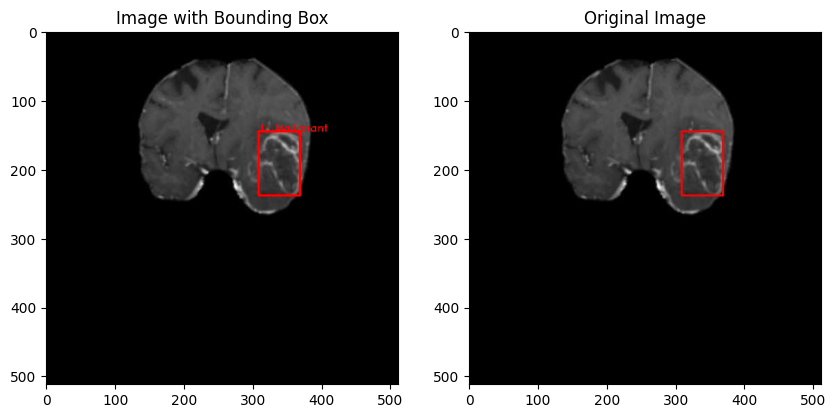

761-70 (8) 308 368 145 238


In [ ]:
i = np.random.randint(0, len(training_df))
show_img(training_df, i)

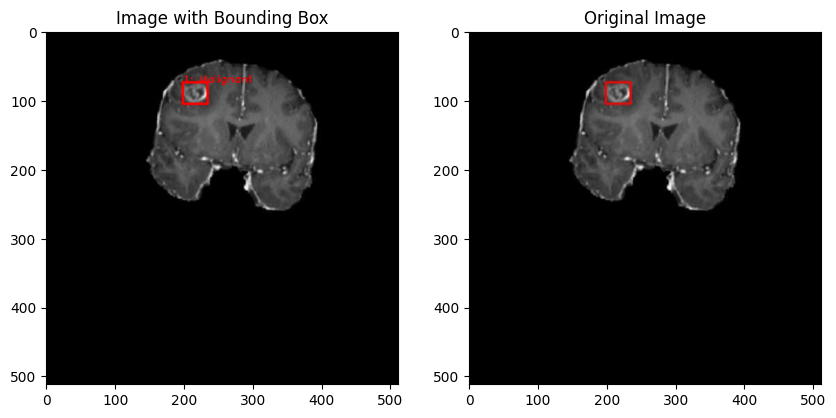

105-val_1 (182) 198 234 74 105


In [ ]:
i = np.random.randint(0, len(validation_df))
show_img(validation_df, i)

## Images Augmentation

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.9),
    A.Rotate(limit=15, p=0.9),
    A.RandomBrightnessContrast(p=0.8),
    A.GaussNoise(p=0.8),
    A.Blur(blur_limit=3, p=0.8),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), p=0.8),
    A.Resize(512, 512),  # Ensure final size is maintained
])

In [ ]:
transform = A.Compose([
    A.RandomBrightnessContrast(p=1),
    A.GaussNoise(p=1),
    A.Blur(blur_limit=3, p=1)
])

In [ ]:
def augment_image(image):
    transformed = transform(image=image)
    return transformed['image']

In [ ]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
aug_image = augment_image(image)

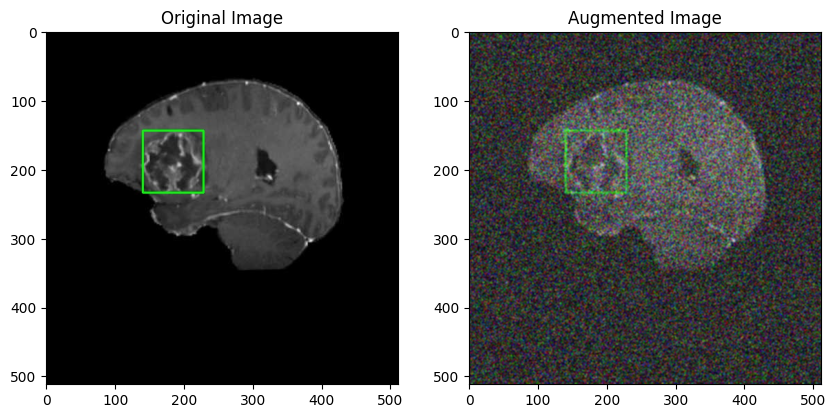

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")

axs[1].imshow(aug_image)
axs[1].set_title("Augmented Image")

plt.show()

In [ ]:
augment = pd.DataFrame(columns=['img_name','img_path','class_id','x_center','y_center','width','height', 'width_pxl', 'height_pxl', 'channels'])

In [ ]:
training_df.head(0)

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels


In [ ]:
dest_path = '/content/drive/MyDrive/SDS CP#24/DataSet/train/training_images/'
for i in range(len(training_df)):
  img_path = training_df.loc[i, 'img_path']
  img_name = training_df.loc[i, 'img_name']
  img_class = training_df.loc[i, 'class_id']
  x_center = training_df.loc[i, 'x_center']
  y_center = training_df.loc[i, 'y_center']
  width = training_df.loc[i, 'width']
  height = training_df.loc[i, 'height']
  width_pxl = training_df.loc[i, 'width_pxl']
  height_pxl = training_df.loc[i, 'height_pxl']
  channels = training_df.loc[i, 'channels']

  image = cv2.imread(img_path)
  aug_image = augment_image(image)
  img_new_name = 'A-'+img_name

  cv2.imwrite(dest_path+img_new_name+'.jpg', aug_image)
  augment.loc[len(augment)] = [img_new_name, dest_path+img_new_name+'.jpg', img_class, x_center, y_center, width, height, width_pxl, height_pxl, channels]
  print(f'{i} Out Of {len(training_df)}')

0 Out Of 925
1 Out Of 925
2 Out Of 925
3 Out Of 925
4 Out Of 925
5 Out Of 925
6 Out Of 925
7 Out Of 925
8 Out Of 925
9 Out Of 925
10 Out Of 925
11 Out Of 925
12 Out Of 925
13 Out Of 925
14 Out Of 925
15 Out Of 925
16 Out Of 925
17 Out Of 925
18 Out Of 925
19 Out Of 925
20 Out Of 925
21 Out Of 925
22 Out Of 925
23 Out Of 925
24 Out Of 925
25 Out Of 925
26 Out Of 925
27 Out Of 925
28 Out Of 925
29 Out Of 925
30 Out Of 925
31 Out Of 925
32 Out Of 925
33 Out Of 925
34 Out Of 925
35 Out Of 925
36 Out Of 925
37 Out Of 925
38 Out Of 925
39 Out Of 925
40 Out Of 925
41 Out Of 925
42 Out Of 925
43 Out Of 925
44 Out Of 925
45 Out Of 925
46 Out Of 925
47 Out Of 925
48 Out Of 925
49 Out Of 925
50 Out Of 925
51 Out Of 925
52 Out Of 925
53 Out Of 925
54 Out Of 925
55 Out Of 925
56 Out Of 925
57 Out Of 925
58 Out Of 925
59 Out Of 925
60 Out Of 925
61 Out Of 925
62 Out Of 925
63 Out Of 925
64 Out Of 925
65 Out Of 925
66 Out Of 925
67 Out Of 925
68 Out Of 925
69 Out Of 925
70 Out Of 925
71 Out Of 925
72

In [ ]:
augment.shape

(925, 10)

In [ ]:
augment.head()

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels
0,A-0-00064_140,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.360329,0.370305,0.173709,0.174883,512.0,512.0,3.0
1,A-1-00056_129,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.520540,0.448944,0.233568,0.132629,512.0,512.0,3.0
2,A-2-00060_71,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.524061,0.452465,0.172535,0.139671,512.0,512.0,3.0
3,A-3-00059_122,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.460681,0.404343,0.174883,0.111502,512.0,512.0,3.0
4,A-4-00061_127,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.569249,0.485329,0.091549,0.085681,512.0,512.0,3.0


In [ ]:
training_df.head()

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels
0,0-00064_140,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.360329,0.370305,0.173709,0.174883,512.0,512.0,3.0
1,1-00056_129,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.520540,0.448944,0.233568,0.132629,512.0,512.0,3.0
2,2-00060_71,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.524061,0.452465,0.172535,0.139671,512.0,512.0,3.0
3,3-00059_122,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.460681,0.404343,0.174883,0.111502,512.0,512.0,3.0
4,4-00061_127,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.569249,0.485329,0.091549,0.085681,512.0,512.0,3.0


In [ ]:
training_df = pd.concat([training_df, augment], ignore_index=True)

In [ ]:
training_df.shape

(1850, 10)

In [ ]:
training_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/training_df.csv', index=False)

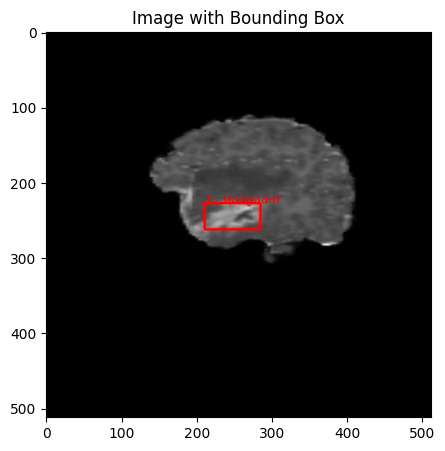

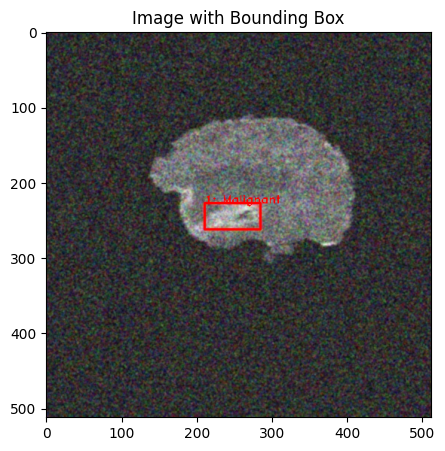

In [ ]:
i = np.random.randint(0, len(training_df))
if i > 924:
  j= i-925
else:
  j = i+925


show_img(training_df, i)

show_img(training_df, j)
